# 7.2 Bayesian Linear Models

## Instructions
1. Read through the code and descriptions, make sure you understand each line of code.
2. There is functionality missing in the functions `show_posterior_surface` and  `draw_sample_models`.  Fill in the missing functionality.
3. Answer the questions at the end of the worksheet.
4. Submit your completed worksheet to your pre-class work GitHub repository before the start of class.

## Bayesian linear models

This script provides a very basic introduction to making prediction with Bayesian linear models.
Some of the functionality is missing and will need to be added before the entire script works.

First we generate a data set.  Since this dataset is randomly generated, each time you run this cell you will get a new dataset to observe:

<IPython.core.display.Javascript object>


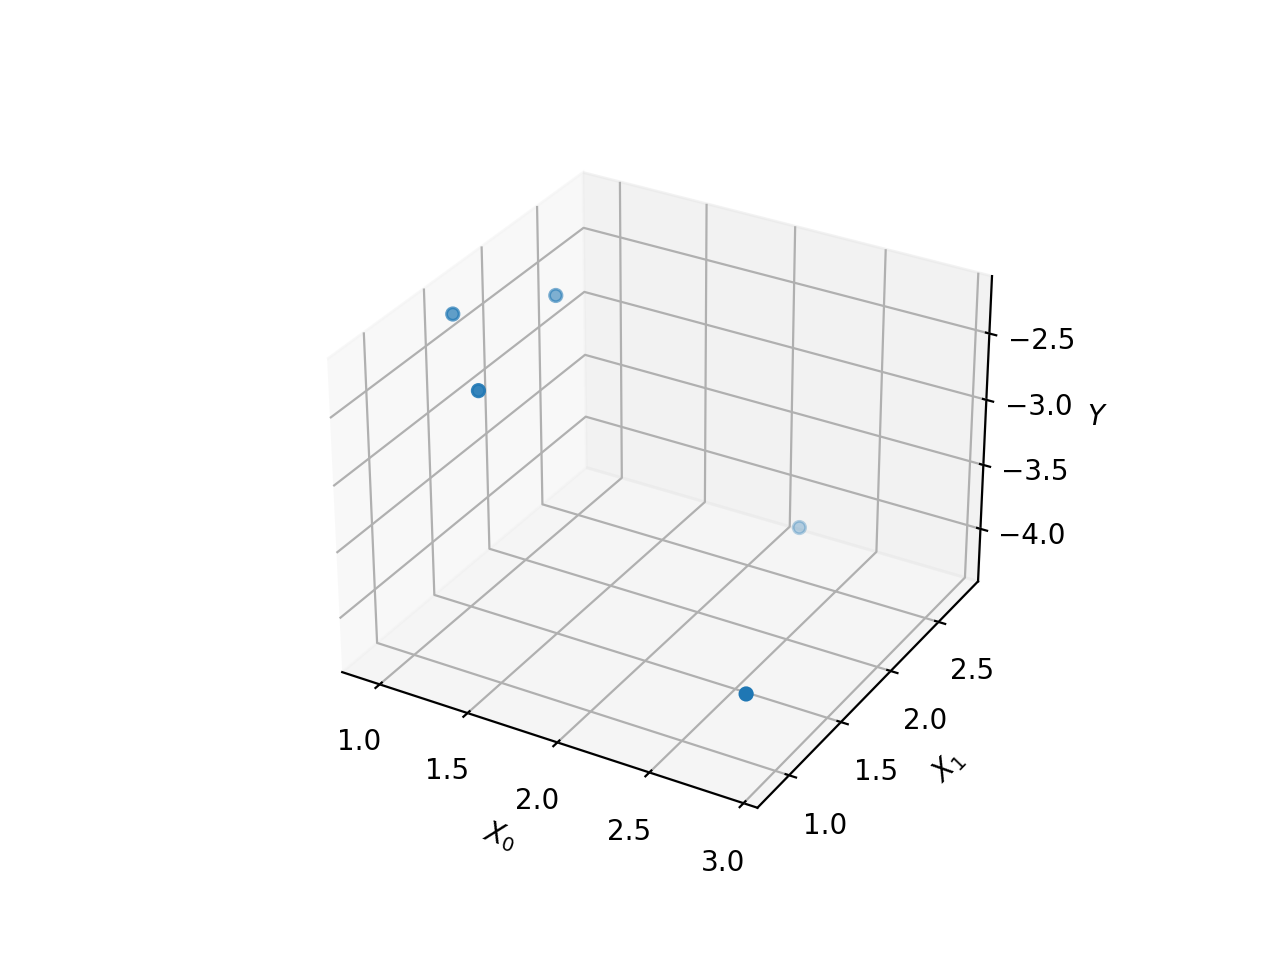

In [56]:
# If you are running this notebook locally  with ipython use:
# %matplotlib notebook
# and you will get beautiful rotatable graphs!

import numpy as np
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook
from scipy import stats
from sklearn.linear_model import BayesianRidge


TRUE_MODEL_WEIGHTS = np.array([-1.0, -1.0])
N = 5
shape = (N, 2)
sigma = 1.0
vmax = 3

w_1 = np.arange(-3, 3, 0.1)
w_2 = np.arange(-3, 3, 0.1)


def linear(w, x):
    return np.dot(w, x.T)


def rand_inputs(shape, vmax):
    return vmax * np.random.rand(*shape)


def rand_outputs(inputs, sigma):
    true_output = linear(TRUE_MODEL_WEIGHTS, inputs)
    noise = sigma * np.random.rand(*true_output.shape)
    return true_output + noise


xs = rand_inputs(shape, vmax)
ys = rand_outputs(xs, sigma)


def plot_data(title=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(xs[:, 0], xs[:, 1], ys)
    ax.set_xlabel('$X_0$')
    ax.set_ylabel('$X_1$')
    ax.set_zlabel('$Y$')
    if title is not None:
        plt.title(title)

    return ax


_ = plot_data()


### Likelihood
Given the data, we can now look at the likelihood of the data.
Strictly speaking, this is a continuous function, but we will approximate this continuous function with a multidimensional grid of points over a plausible area of the model parameters.  In the figure below we plot the log-likelihood function since this is much nicer to visualize (as well as being more numerically stable).

<IPython.core.display.Javascript object>


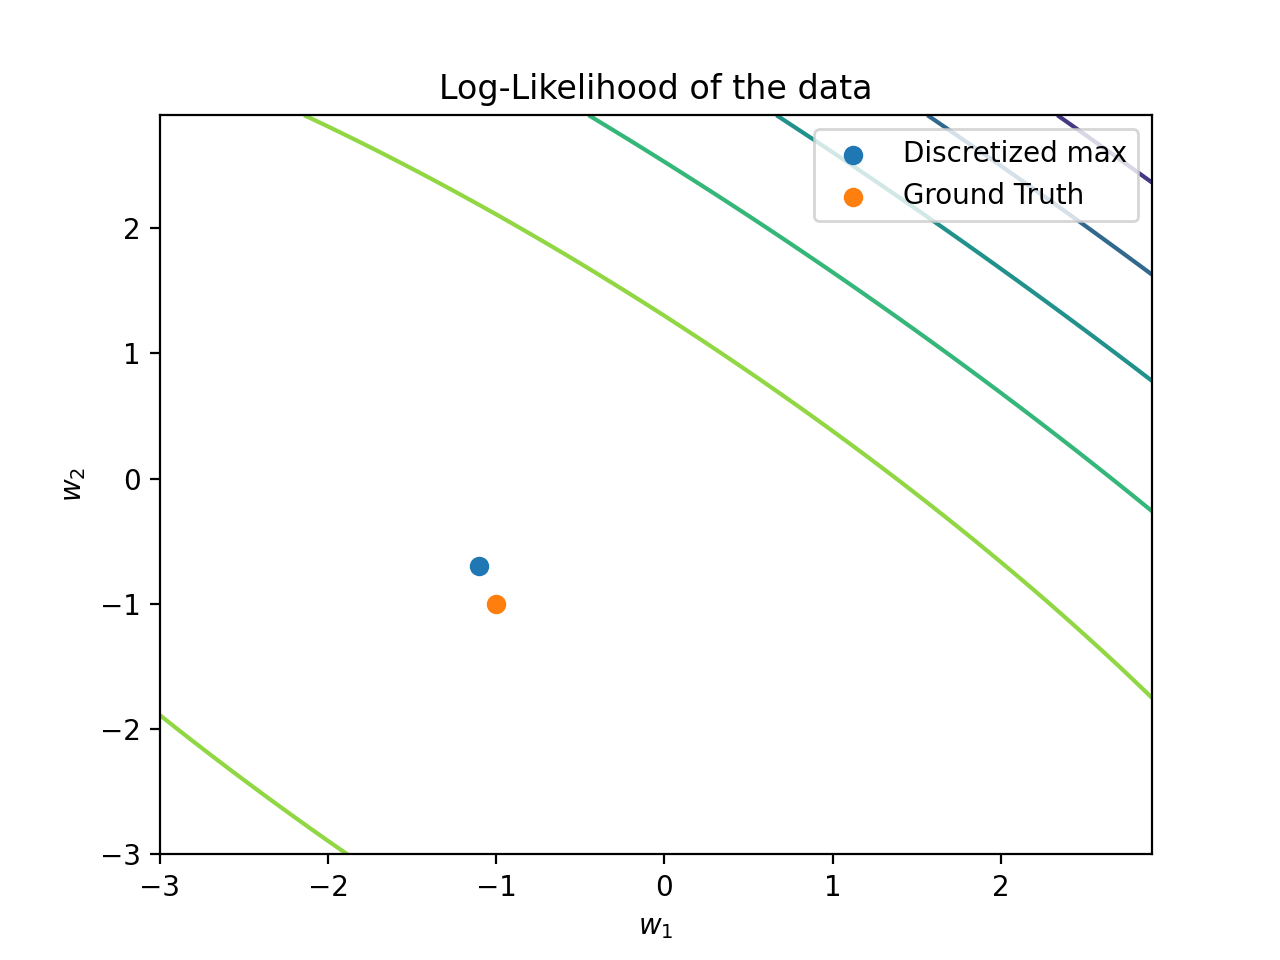

In [57]:
def loglikelihood(w, x, y, sigma):
    return -sum((y - np.dot(w, x.T))**2) / sigma


def standard_plot(Z, title=None):
    plt.figure()
    max_ind = np.unravel_index(Z.argmax(), Z.shape)
    plt.contour(w_1, w_2, Z)
    plt.scatter(w_1[max_ind[0]], w_2[max_ind[1]], label="Discretized max")
    plt.scatter(
        TRUE_MODEL_WEIGHTS[0], TRUE_MODEL_WEIGHTS[1], label="Ground Truth")
    plt.legend()
    plt.xlabel("$w_1$")
    plt.ylabel("$w_2$")
    if title is not None:
        plt.title(title)


def show_log_likelihood_surface(x, y, sigma, estimates=None):
    Z = np.zeros((w_1.size, w_2.size))

    for (i, w_i) in enumerate(w_1):
        for (j, w_j) in enumerate(w_2):
            w_hat = np.array([w_i, w_j])
            Z[i, j] = loglikelihood(w_hat, x, y, sigma)

    standard_plot(Z, "Log-Likelihood of the data")
    return Z


log_likelihood = show_log_likelihood_surface(xs, ys, 1.0)



### Prior
As good Bayesians, we also provide a prior belief over our model parameters.  In this case we use a Normal distribution centered around zero to encode our belief that the weights are not large (i.e. far from zero).  Again we are plotting everything in log-space.

<IPython.core.display.Javascript object>


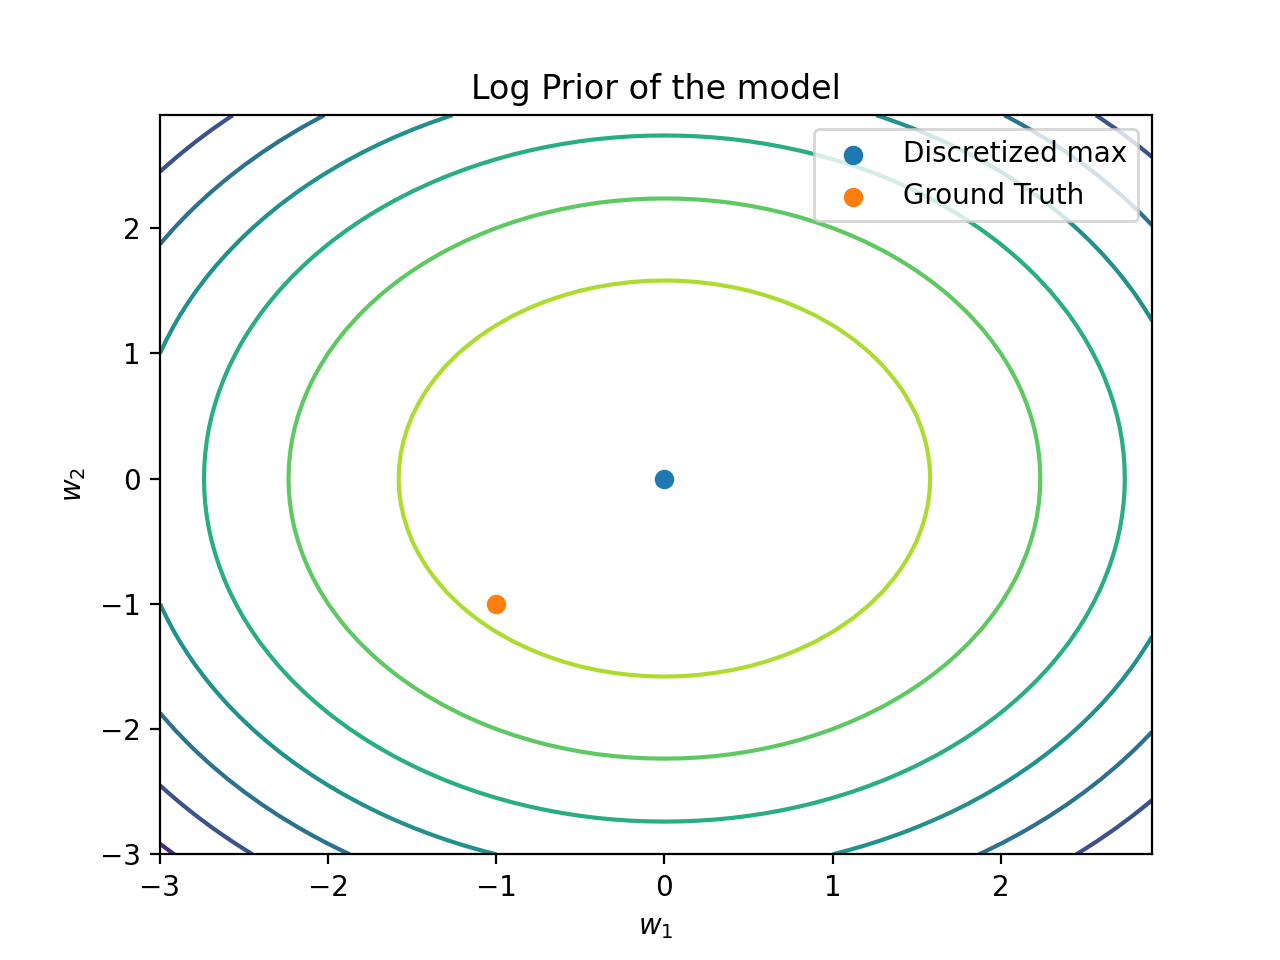

In [58]:
def show_log_prior_surface(sigma):
    W_1, W_2 = np.meshgrid(w_1, w_2, sparse=False, indexing='ij')
    W_1 = -(W_1**2)
    W_2 = -(W_2**2)
    Z = (W_1 + W_2) / sigma

    standard_plot(Z, "Log Prior of the model")
    return Z


log_prior = show_log_prior_surface(1.0)


### Posterior
Since our prior and likelihood plots have been in log-space we can get the posterior plot through simple addition (since addition in log-space corresponds to multiplication in normal space). However it is useful to also see the actual posterior.

### Task
1. Write code to transform the data into a proper posterior distribution.  Since the distribution is given in log-space, you will need to exponentiate the distribution and normalize it, so that it sums to 1.

<IPython.core.display.Javascript object>


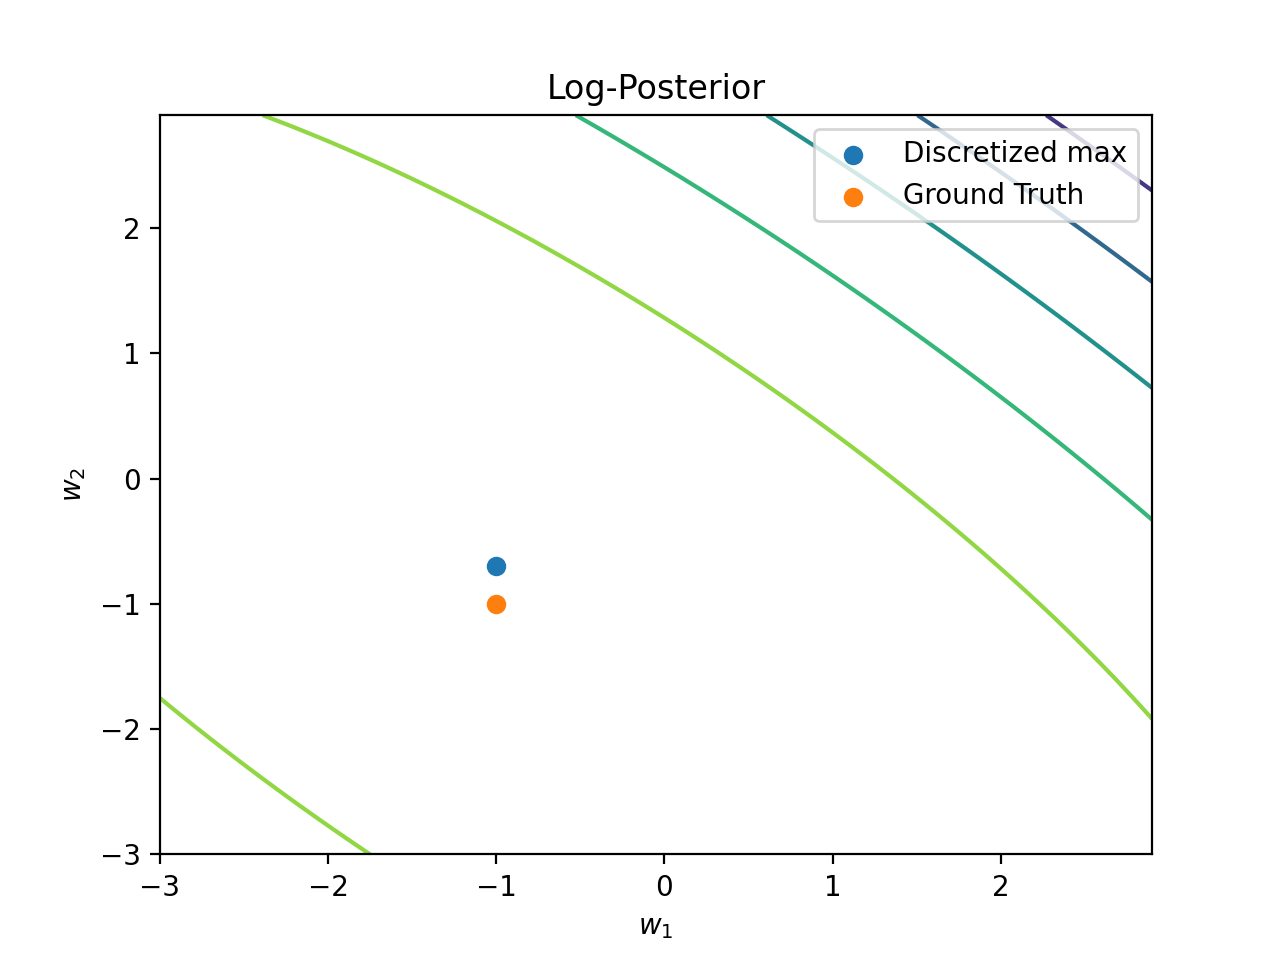

<IPython.core.display.Javascript object>


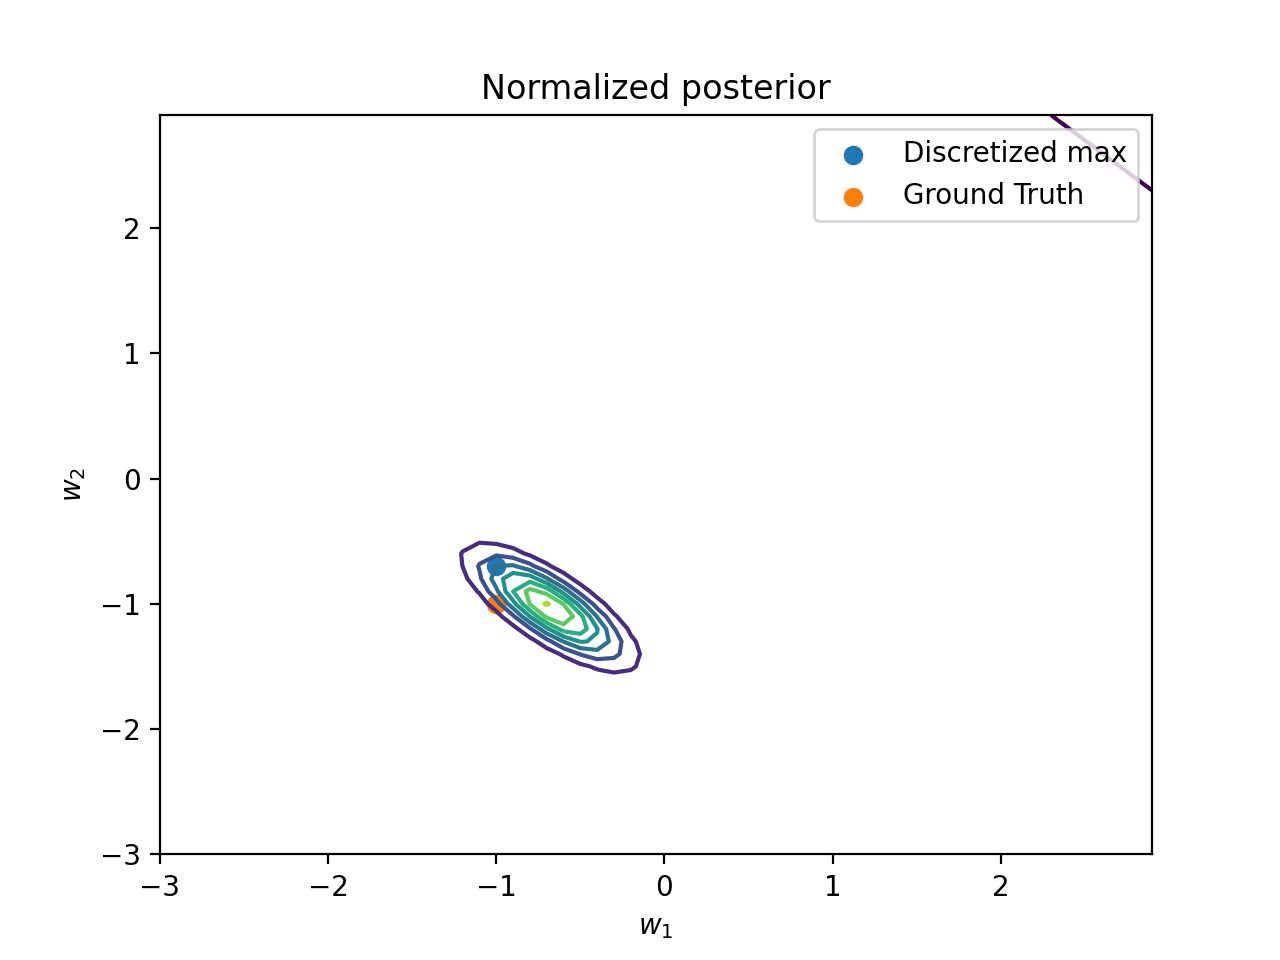

In [62]:
def show_log_posterior_surface(prior, likelihood):
    Z = prior + likelihood
    standard_plot(Z, "Log-Posterior")
    return Z

def show_posterior_surface(log_posterior):
    
    #Take the exponent of the log posterior and normalize
    posterior = np.exp(log_posterior)
    
    #Normalize the posterior: sum over all values and divide each value by the sum
    normalized_posterior = posterior/posterior.sum()
    
    #Plot the normalized posterior distribution
    standard_plot(normalized_posterior, "Normalized posterior")
    return normalized_posterior

log_posterior = show_log_posterior_surface(log_prior, log_likelihood)
posterior = show_posterior_surface(log_posterior)

### Samples
Now that we have a proper (discrete) distribution, we can draw samples from the distribution and show the predictions that those models make.

##### Task
1. Write code to draw `n` samples from the posterior distribution.  Here a single sample will return an entire model (this model is parameterized by the tuple `(w_1,w_2)`, so a single sample should return those two parameters).

<IPython.core.display.Javascript object>


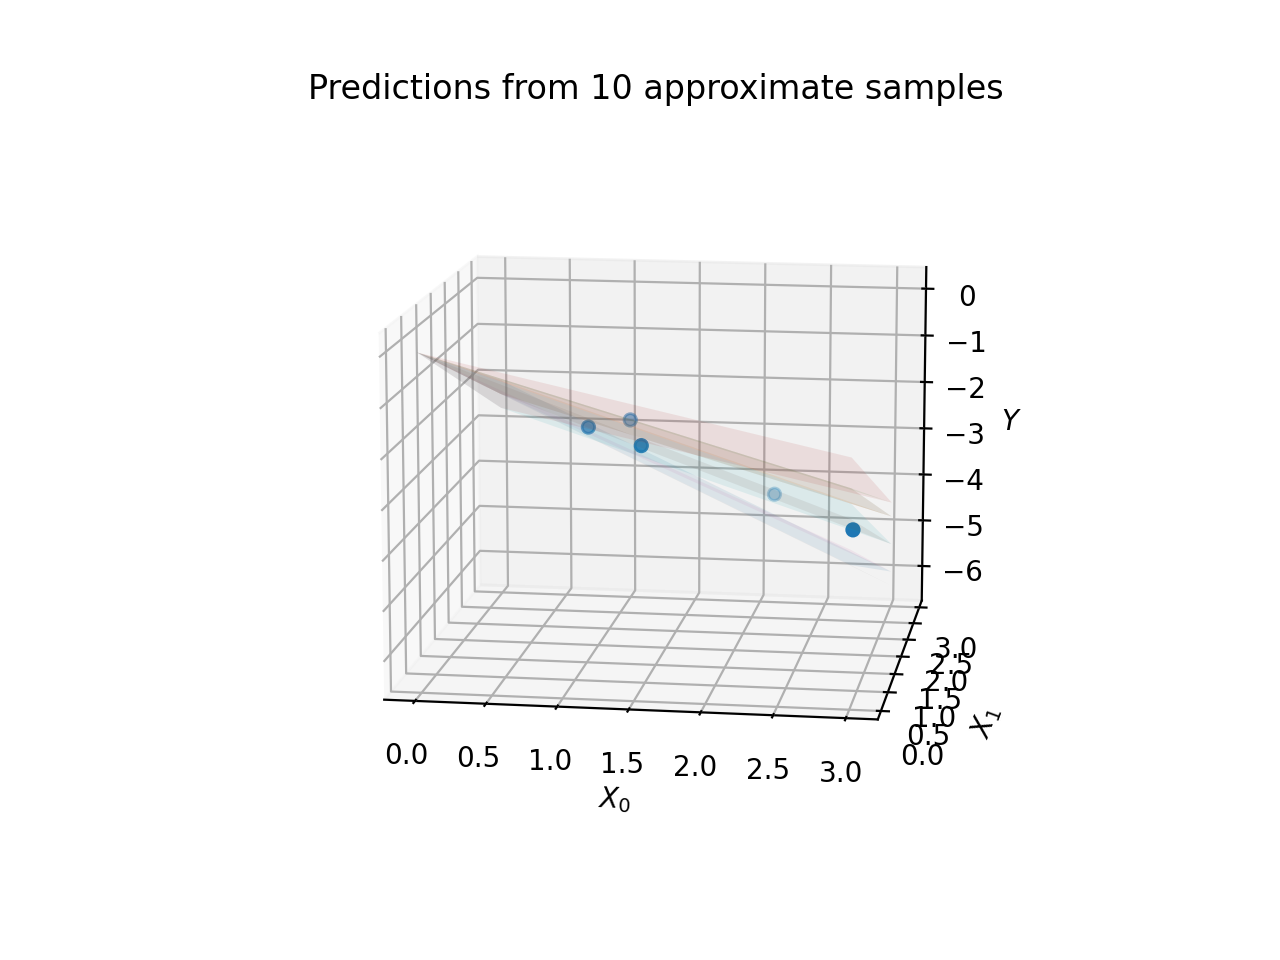

In [68]:
# Draw some samples from the posterior!
from itertools import product

def draw_sample_models(n, posterior):
    # Hint: the code below is not actually sampling from a posterior!
    # TODO: Make it sample from the posterior!
    
    #Store all possible permutations of the weights
    w = [*map(list,product(w_1,w_2))]
    
    #Randomly pick n weight pairs
    idx = np.random.choice([*range(len(w))], n, replace= True, p = posterior.flatten())
    
    #Return the chosen samples
    return np.array([w[i] for i in idx])

def draw_sample_models(n, posterior):
    # The idea here is that we will sample values for each w with the sample weights obtained from the posterior  distribution. 
    w  = np.random.choice(np.arange(posterior.size), size = n, p = posterior.flatten())
    w1, w2 = np.unravel_index(w, posterior.shape)

    return np.array((tuple(zip(w_1[w1], w_2[w2]))))

N_samples = 10
ws = draw_sample_models(N_samples, posterior)
flat_posterior = posterior.flatten()


def show_model(ax, w):
    X = np.array([[0.0, 0.0], [0.0, vmax], [vmax, 0.0], [vmax, vmax]])
    X0 = X[:, 0].reshape((2, 2))
    X1 = X[:, 1].reshape((2, 2))

    Z = linear(w, X).reshape((2, 2))
    ax.plot_surface(X0, X1, Z, alpha=1.0 / N_samples)


ax = plot_data("Predictions from 10 approximate samples")
for ind in range(N_samples):
    show_model(ax, ws[ind,:])


### `scikit.learn.BayesianRidge`
In this particular case the model is simple enough that we don't need to use a discrete approximation and can instead find analytical solutions.  This has been coded up into `BayesianRidge` and is a part of scikit.learn.  When examining the results, notice that the error bars for the predictions increase as we move away from data that has already been seen.

##### Task
1. Find the online documentation for `BayesianRidge` to determine what model is being fitted, and what the parameters and hyperparameters are.

(Note that the `return_std` option was only recently added to BayesianRidge (Dec 2016). If the code fails then please try updating your version of scikit.learn!)

<IPython.core.display.Javascript object>


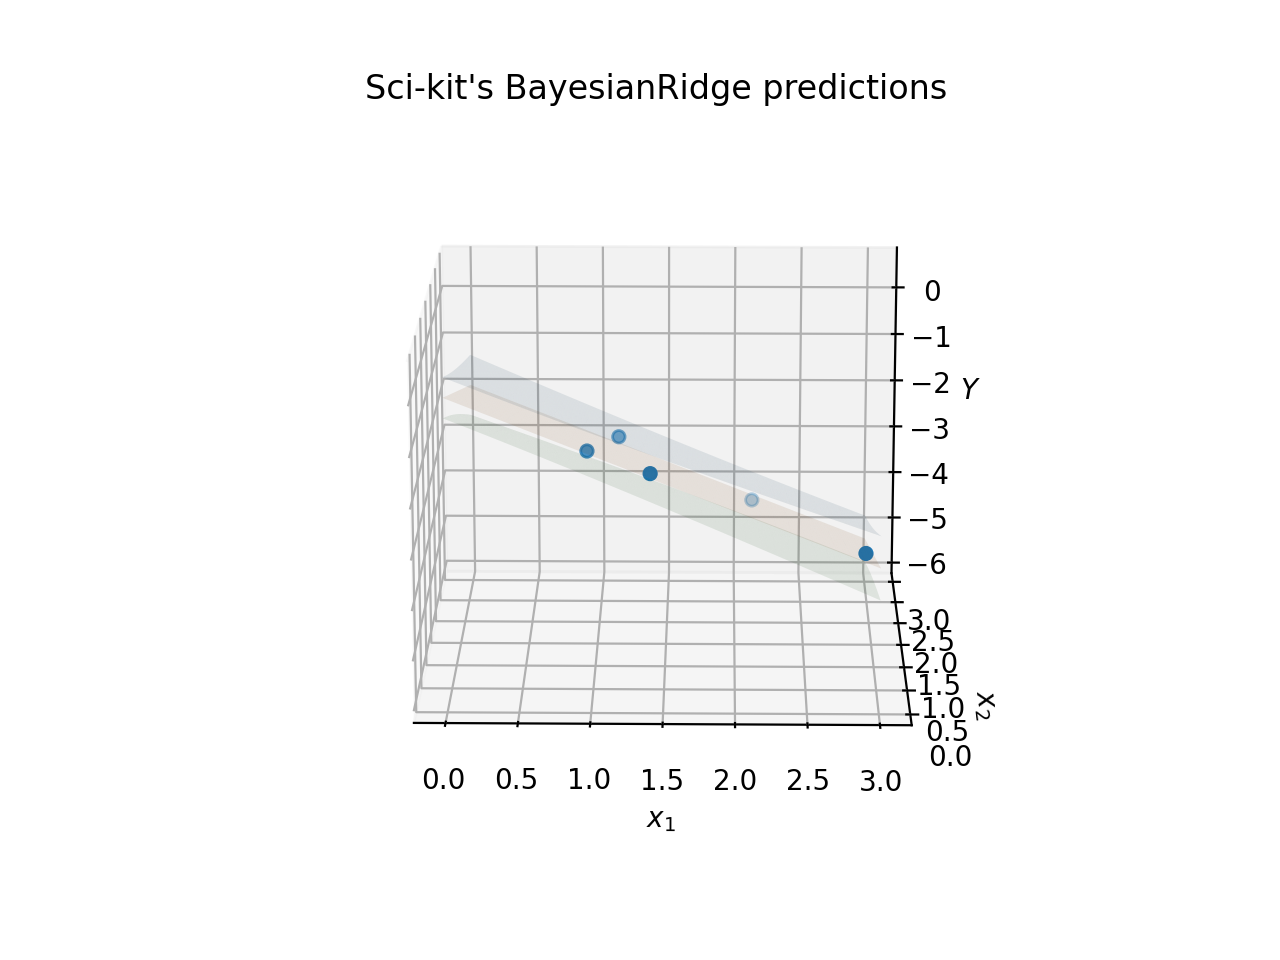

In [69]:
N_grid = 30


def error_bars(clf, title=None):
    x = np.linspace(0, vmax, N_grid)
    X0, X1 = np.meshgrid(x, x)
    X = np.vstack((X0.flatten(), X1.flatten())).T
    Y_hat, Y_std = clf.predict(X, return_std=True)
    Y_hat = Y_hat.reshape((N_grid, N_grid))
    Y_std = Y_std.reshape((N_grid, N_grid))

    ax = plot_data()

    ax.plot_surface(X0, X1, Y_hat + 1.96 * Y_std, alpha=0.1, label="Lower")
    ax.plot_surface(X0, X1, Y_hat, alpha=0.1, label="Mean")
    ax.plot_surface(X0, X1, Y_hat - 1.96 * Y_std, alpha=0.1, label="Upper")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    if title is not None:
        plt.title(title)


clf = BayesianRidge(compute_score=True, fit_intercept=False)
clf.fit(xs, ys)
error_bars(clf, "Sci-kit's BayesianRidge predictions")


### Questions

1. Given that we now have a number of models drawn from a posterior, how should we make a prediction for a single point?
2. How do the models' predictions behave for points far away from observed data?
3. What model does the maximum likelihood model correspond to?
4. How does the behavior of the Bayesian linear model change as we observe more data?
5. What other steps does the scikit learn BayesianRidge perform that we don't (list all of them)
6. What hyperparameter(s) are in this model?
7. Why don't we approximate more posterior distributions with a multi-dimensional grid of points?
8. What are the similarities and differences between Bayesian & frequentist approaches to statistics?

1. How we might make predictions for a single point:

    - Run each model through the prediction process such that you have a range of values for the prediction – this helps convey uncertainty from the parameters

    - We can take the mean of the model parameters drawn from the posterior to serve as our best estimate of the parameter. We then simply plug in the new point to get the prediction

2. The model's predictions diverge. Have more variance. Showing increased uncertainty

3. The model in which the observed data is most probable

4. The more data, we observe, the less uncertain we are. Essentially, the lines converge more and more

5. Steps that the scikit learn BayesianRidge perform that we don't:
    - Fits a Bayesian ridge model
    - Optimizing the hyperparameters 
    
6. Based on the BayesianRidge documentation, the hyperparameters are:
    - alpha_1: shape parameter for the Gamma distribution prior over the alpha parameter
    - alpha_2: inverse scale parameter (rate parameter) for the Gamma distribution prior over the alpha parameter
    - lambda_1: shape parameter for the Gamma distribution prior over the lambda parameter
    - lambda_2: inverse scale parameter (rate parameter) for the Gamma distribution prior over the lambda parameter
   
   
7. 


8. Similarities and differences between Bayesian & frequentist approaches to statistics

    Differences
    - Bayesian incorporates prior belief and knowledge
    - Bayesian expresses uncertainty through use of probability distributions while Frequentist uses confidence intervals
    - Bayesian uses credible intervals while Frequentist uses confidence intervals
    - The above is because: Bayesian treats parameters as random variables when Frequentist treats them as fixed
    
    Similarities
    - Both incorporate the data
    - Convergence with more data

Anticorrelation is a thing: so when one increases the other decreases. And if you're doing good bayesianism, you have to model that.

Some models do not have any sort of probablistic interpretation

Bayesian: Maybe less worry about overfitting in the limit of data

Regularization -> Prior
